# Day 3, Session 1, Amir Haji-Akbari

Systems:
- **Water in confinement**

We are going to simulate water in slit pores. Each group will simulate a system with a _different number of water molecules_ which will correspond to a different thickness of the confined water layer.
    
LAMMPS version: 2 august 2023

Submit the job to the RM-shared queue. Make sure you are in the right folder and have the right files.
<div style="background-color: #74a9cf; padding: 10px;">
<pre style="background-color: #74a9cf;"><code style="background-color: #74a9cf;">
Boxes that appear with this format are for you to run on the terminal (submitting batch jobs in the cluster).
</code></pre>
</div>


# Tutorial: Simulating water in slit pores using LAMMPS

## LAMMPS input file
### 1) Initialization
First, we'll initialize LAMMPS and set up the necessary parameters.

**Input file (in.water-conf-compress):**

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
units           real
boundary        p p f
atom_style      full
neighbor        2.0 bin
neigh_modify    delay 0  every 1 check yes
</code></pre>
</div>

Explanation:

- units real sets units to the real system (e.g., Angstroms for distance, kcal/mol for energy).
- boundary p p f sets periodic boundary conditions in x and y.
- atom_style full is appropriate for molecular systems like water.
- neighbor is used to create a neighbor list with an extra "2.0Å" buffer to the distance cut-off
- neigh_modify controls how often the neighbor list is modified


### 2) System Definition
**Input file (continuation):**

Define simulation setup

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
# Simulation set-up

processors * * 2

pair_style lj/cut/tip4p/long 1 2 1 1 0.1546 12.5
pair_modify mix arithmetic
bond_style      harmonic
angle_style     harmonic

#Long-range interactions

kspace_style pppm/tip4p 0.000100000000000
kspace_modify slab 3.000000000000000
dielectric 1.0

#Force-field parameters

bond_coeff 1 5000 0.9572	#TIP4P-2005, K coeff is irrelevant as we are using a rigid model
angle_coeff 1 500 104.52	#TIP4P-2005, K value is not used as we are using a rigid model

pair_coeff	1	1	0.1852	3.1589	    # O-water #TIP4P-2005
pair_coeff  2   2   0.0     0.0         # H-water
pair_coeff	3	3	0.0859	  3.3997	# C_piston 
pair_coeff  4   4   0.0859    3.3997    # C_piston
</code></pre>
</div>

Read the data file.

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
read_data data.waterInConf${nWater}H2O
</code></pre>
</div>


<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
LAMMPS data file for water in confinement between two graphene sheets

3232 atoms
4 atom types
1600 bonds
1 bond types
800 angles
1 angle types
0 impropers
1 improper types
-1.8420299999999998	30.08661 xlo xhi
-0.709	33.323 ylo yhi
-150 150 zlo zhi

Masses

1 15.9994
2 1.00794
3 12.0107
4 12.0107

Atoms

1 1 3 0.00 0.0 0.0 -50.0 0 0 0
2 1 3 0.00 -1.22802 0.709 -50.0 0 0 0
3 1 3 0.00 -1.22802 2.127 -50.0 0 0 0
.
.
.

1184 119 1 -1.1128 17.569398 12.84212 -15.492978 0 0 0
1185 119 2 0.5564 16.697316 13.331344 -15.477184 0 0 0
1186 119 2 0.5564 18.321432 13.500089 -15.452484 0 0 0
.
.
.

Bonds

1 1 833 834
2 1 833 835
3 1 836 837
.
.
.

Angles

1 1 834 833 835
2 1 837 836 838
3 1 840 839 841
.
.
.

</code></pre>
</div>

Below are three images showing how the system was put together.

**Step 1**: Graphene sheets were created using VMD (nanobuilder)

**Step 2**: A water box was created using Packmol

**Step 3**: A python script was used to combine the water box and the graphene sheets to create the data file.

In [3]:
from IPython.display import Image, display_html

# Paths to your images
image_path1 = "just-water.png"
image_path2 = "just-sheets.png"
image_path3 = "water-and-sheets.png"

# Create HTML for displaying images side by side
html_code = f"""
<div>
    <img src="{image_path2}" width="250" style="float: left; margin-right: 10px"/>
    <img src="{image_path1}" width="250" style="float: left; margin-right: 10px"/>
    <img src="{image_path3}" width="250" style="float: left"/>
</div>
"""

# Display the HTML
display_html(html_code, raw=True)

**Input file (continuation):**

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
# define groups
group hydWater type 2
group oxWater type 1
group pist1 type 3
group pist2 type 4
group waterGrp union oxWater hydWater
group pistonGrp union pist1 pist2
</code></pre>
</div>


Explanation:
- It is sometimes useful to create groups of atoms, which will be useful later in the script to apply some fixes.

**Input file (continuation):**

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
fix myNVT waterGrp nvt temp 300.000000000000000 300.000000000000000 200.000000000000000   # Allow energy to fluctuate (remove high energies)

fix wallLowStr all wall/lj93  zlo EDGE 1.000000000000000 1.000000000000000 1.100000000000000 
fix wallHighStr all wall/lj93  zhi EDGE 1.000000000000000 1.000000000000000 1.100000000000000 
fix shakeFixwaterGrpStr waterGrp shake 0.0001 200 0 b 1 a 1

dump myDump  all custom 1000 ${tag}.dump.xyz id mol type q x y z
dump_modify  myDump append yes sort id format line "%d %d %d %8.4f %20.15f %20.15f %20.15f"

thermo 100
timestep 2.0

#These compute commands are used to conduct diagnostic computations. Can be used to obtain instantaneous measures

compute binId waterGrp chunk/atom bin/1d z lower 0.1 units box
compute qVal waterGrp property/atom q 
compute peVal waterGrp pe/atom
compute  molChunk waterGrp chunk/atom molecule
compute  dipoleCmpt waterGrp dipole/tip4p/chunk molChunk
compute  comCmpt waterGrp com/chunk molChunk

#The following fixes are used to calculate running averages for a couple of properties

fix avDen all ave/chunk 20 1 20 binId density/mass c_qVal c_peVal ave running file ${tag}-num-Den.txt overwrite
fix indDpl all ave/time 20 1 20 c_comCmpt[*] c_dipoleCmpt[*] file ${tag}.dpl.all.txt mode vector 

run ${prodSteps}
</code></pre>
</div>

Explanation:
- We use fixes for different purposes:
    - [fix nvt] Apply NVT ensemble for a selected group of atoms
    - [fix wall/lj93] Apply a bound on one or more faces of the simulation boxes by applying a flat wall that interacts with other atoms in the simulation box. "93" here refers to the 9-3 Lennard-Jones potential.
    - [fix shake] Apply the SHAKE algorithm to constraint the bond and angles for the water molecules (needed when simulating rigid models of water)

## Running the Simulation in the terminal 

First, let us look at the submission script that we will use to run the simulation.
<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
#!/bin/bash
#SBATCH -A see220002p
#SBATCH -p RM-shared
#SBATCH -n 8
#SBATCH -N 1
#SBATCH -t 2:00:00

module load intel
module load intel-mpi

mpirun -n ${SLURM_JOB_CPUS_PER_NODE} ../../../shared/LAMMPS/bin/lmp_mpi -in in.water-conf-prod-nvt -v inFileName relaxed-$1H2
O-$2.dat.out -v prodSteps 25000 -v tag water-slit-pore-n$1-$2-analysis -log log-n$1-$2-a.log
</code></pre>
</div>

Submit the job to the RM-shared queue. Make sure you are in the right folder and have the right files. You will only need to run the production for this system for an equilibrated configuration, as the equilibrating these systems take time and would not be doable in the duration of this session.
<div style="background-color: #74a9cf; padding: 10px;">
<pre style="background-color: #74a9cf;"><code style="background-color: #74a9cf;">
cd ~/7th_workshop_MD/day_three/session1/Water-Slit-Pore
sbatch analysis.cmd ${N} 10
</code></pre>
</div>


### Check the output files

<font color='red'>**To do for students: Check how the thermodynamic properties of the system change as the system is running**</font>

water-slit-pore-n1000-10-analysis-num-Den.txt
<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
# Chunk-averaged data for fix avDen and group all
# Timestep Number-of-chunks Total-count
# Chunk Coord1 Ncount density/mass c_qVal c_peVal
25000 3000 3753000
  1 -149.95 0 0 0 0
  2 -149.85 0 0 0 0
  3 -149.75 0 0 0 0
  4 -149.65 0 0 0 0
  .
  .
  .
  1497 -0.35 10.3389 0.938487 0.0113566 -3.58343
  1498 -0.25 10.5284 0.934446 0.0223192 -3.55627
  1499 -0.15 10.5588 0.954876 0.00955903 -3.71459
  1500 -0.05 10.3973 0.950924 0.000126883 -3.76997
  1501 0.05 10.4884 0.952694 0.00113451 -3.75591
  1502 0.15 10.4277 0.958534 -0.0012438 -3.74833
  1503 0.25 10.725 0.990584 -0.00847919 -3.90157
  1504 0.35 10.6954 0.98555 -0.00290971 -3.87181
  .
  .
  .
  3000 149.95 0 0 0 0
</code></pre>
</div>

water-slit-pore-n800-8-analysis.dpl.all.txt

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
# Time-averaged data for fix indDpl
# TimeStep Number-of-rows
# Row c_comCmpt[1] c_comCmpt[2] c_comCmpt[3] c_dipoleCmpt[1] c_dipoleCmpt[2] c_dipoleCmpt[3] c_dipoleCmpt[4]
0 801
1 0 0 0 0 0 0 0
2 -43.969 -26.5278 4.94005 -0.237711 -0.0349542 0.415458 0.479931
3 -98.3512 135.875 5.58112 -0.289739 -0.102985 0.368482 0.479931
4 -46.3667 -41.9913 9.47363 0.364543 0.186839 -0.250066 0.479931
5 -33.4203 -6.69998 5.49665 0.258394 0.147148 0.376714 0.479931
.
.
.
800 105.279 -2.64471 0.846199 -0.136085 0.237045 -0.394493 0.479931
801 13.6574 117.116 -9.87291 -0.394428 0.272614 0.0210248 0.479931
1 801
.
.
.
</code></pre>
</div>

water-slit-pore-n1000-10-analysis.dump.xyz

<div style="background-color: #f0f0f0; padding: 10px;">
<pre style="background-color: #f0f0f0;"><code style="background-color: #f0f0f0;">
ITEM: TIMESTEP
0
ITEM: NUMBER OF ATOMS
3832
ITEM: BOX BOUNDS pp pp ff
-1.8420299999999998e+00 3.0086610000000000e+01
-7.0899999999999996e-01 3.3323000000000000e+01
-1.5000000000000000e+02 1.5000000000000000e+02
ITEM: ATOMS id mol type q x y z
1 1 3   0.0000    0.000000000000000    0.000000000000000  -14.519096394668605
2 1 3   0.0000   -1.228020000000000    0.709000000000000  -14.519096394668605
3 1 3   0.0000   -1.228020000000000    2.127000000000000  -14.519096394668605
.
.
.
</code></pre>
</div>

### Plot water density in confinement

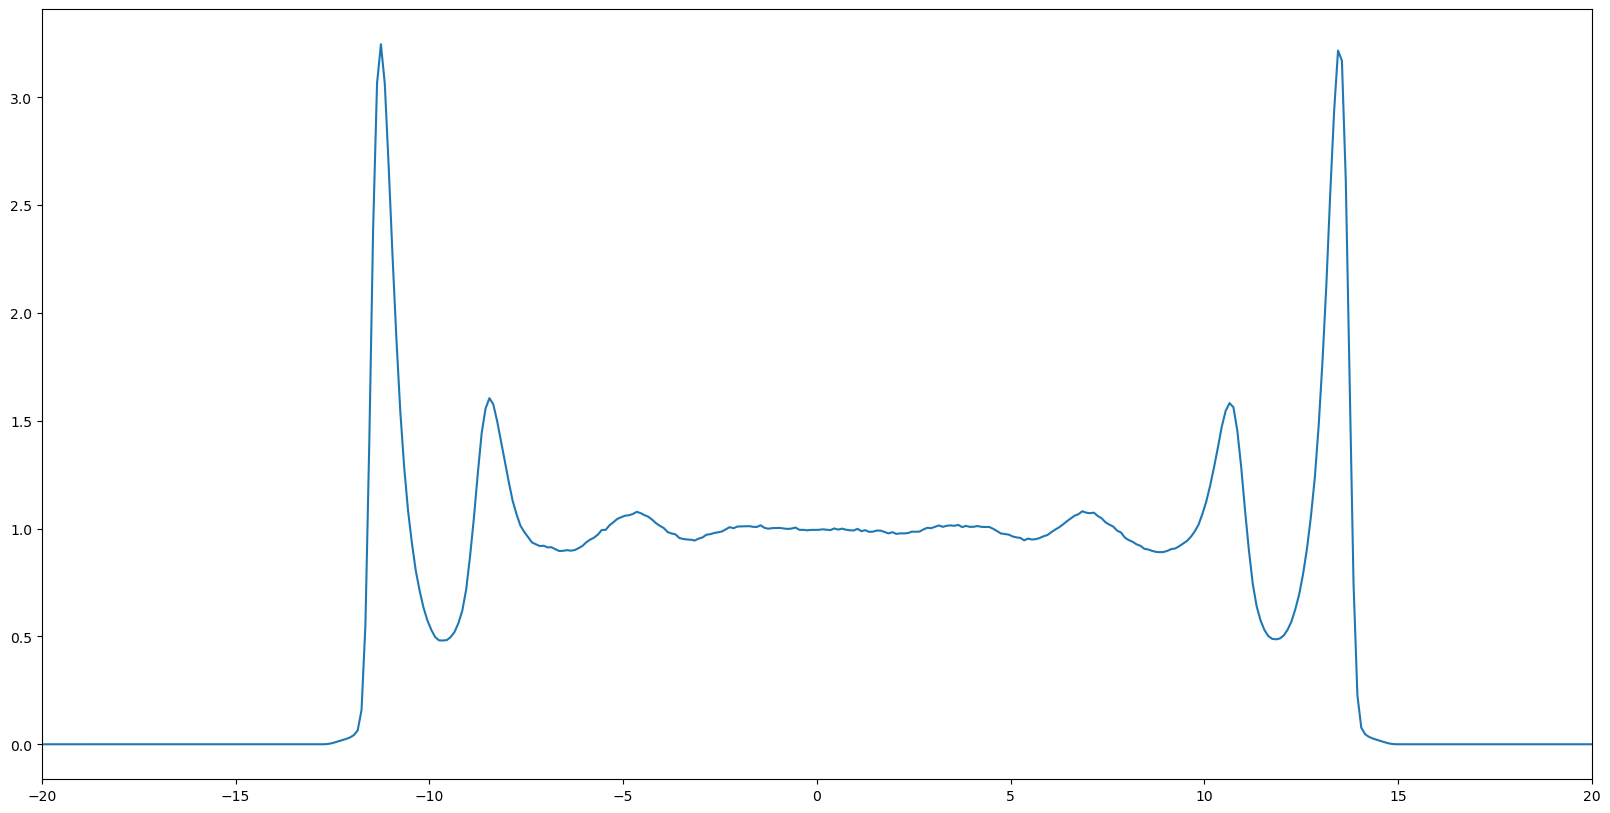

In [4]:
import numpy as np
import matplotlib.pyplot as plt

f = open('/ocean/projects/see220002p/omark/7th_workshop_MD/Folder-for-Omar/Water-Slit-Pore-LongSim/water-slit-pore-n1000-10-analysis-num-Den.txt')
data_str = f.readlines()[4:]
f.close()

index = [int(i.split()[0]) for i in data_str]
zCoord = [float(i.split()[1]) for i in data_str]
nCount = [float(i.split()[2]) for i in data_str]
nDen = [float(i.split()[3]) for i in data_str]
charge = [float(i.split()[4]) for i in data_str]
potE = [float(i.split()[5]) for i in data_str]

zCoord = np.array(zCoord)
nDen = np.array(nDen)
charge = np.array(charge)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(zCoord,nDen)

plt.xlim(-20, 20)
plt.show()


### Plot Potential Energy

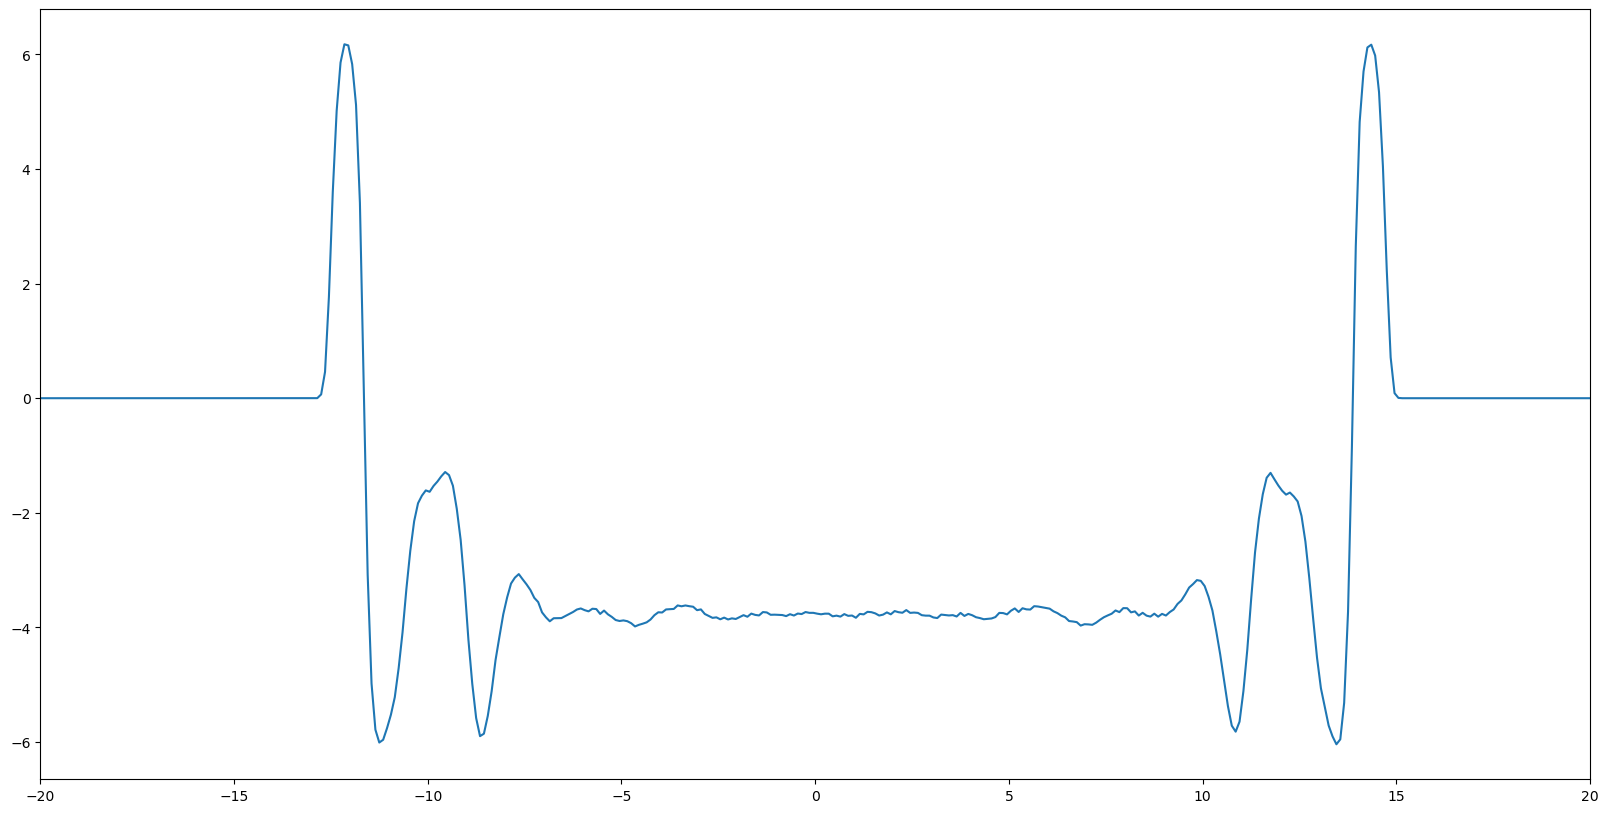

In [4]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(zCoord,potE)

plt.xlim(-20, 20)
plt.show()

### Plot mean charge in confinement

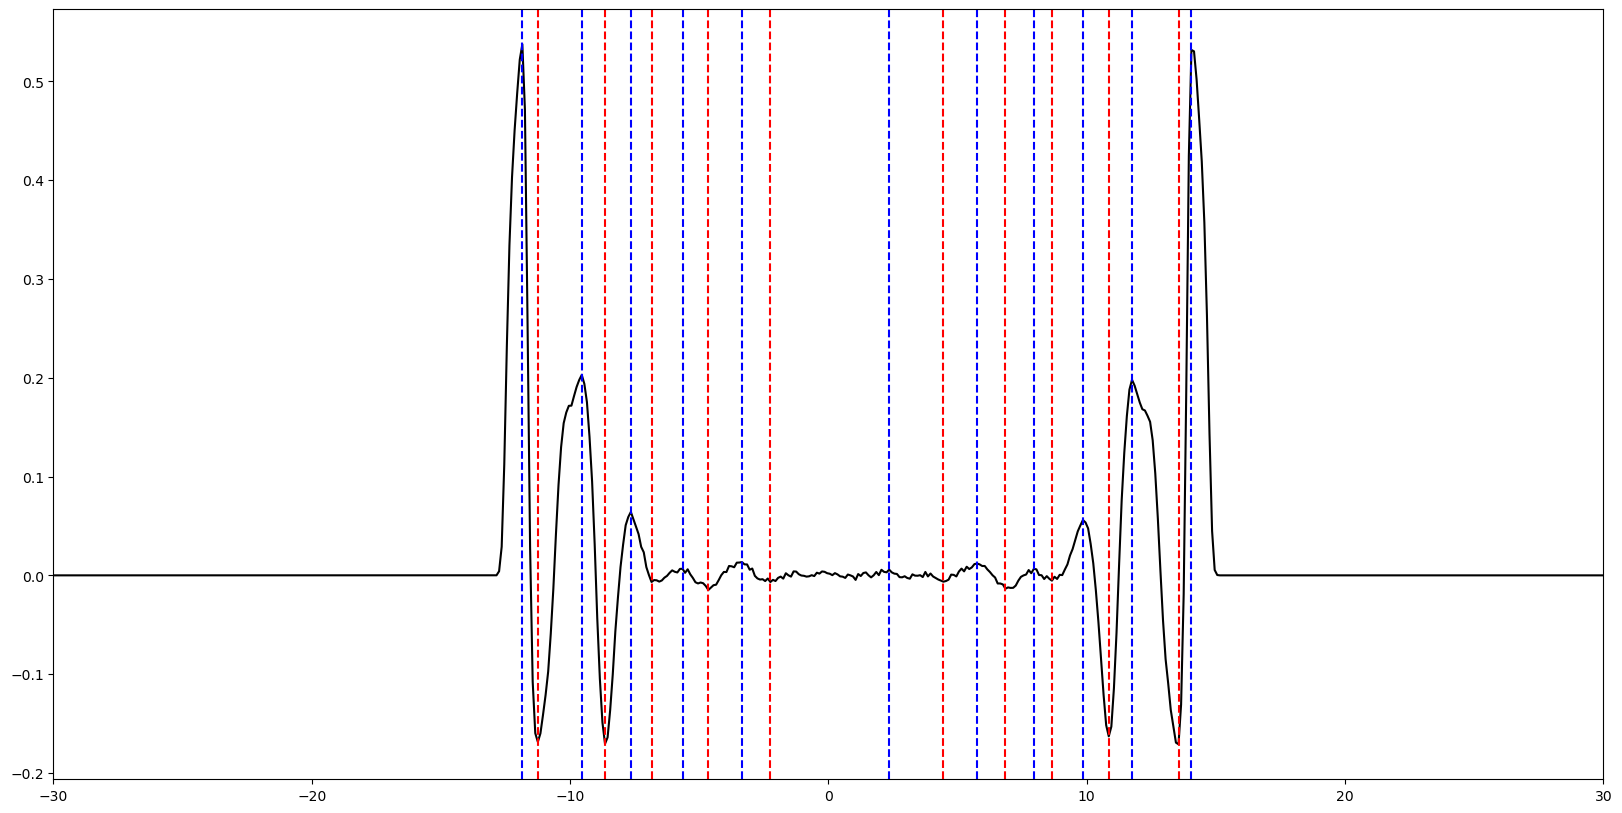

In [5]:
from scipy.signal import find_peaks

minima_indices, _ = find_peaks(-charge, prominence=0.01)
maxima_indices, _ = find_peaks(charge,prominence=0.01)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(zCoord,charge, color='k')

zBinEdge = [-30] # somewhere before the lower sheet
zBinEdgePeaks = []

for idx in minima_indices:
    zBinEdge.append(zCoord[idx])
    plt.axvline(x=zCoord[idx], color='red', linestyle='--', label=f'Minimum at zCoord={zCoord[idx]:.2f}')

for idx in maxima_indices:
    zBinEdgePeaks.append(zCoord[idx])
    plt.axvline(x=zCoord[idx], color='blue', linestyle='--', label=f'Maximum at zCoord={zCoord[idx]:.2f}')
zBinEdge.append(30)
plt.xlim(-30, 30)
plt.show()


### Calculate dipoles for water confinement

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

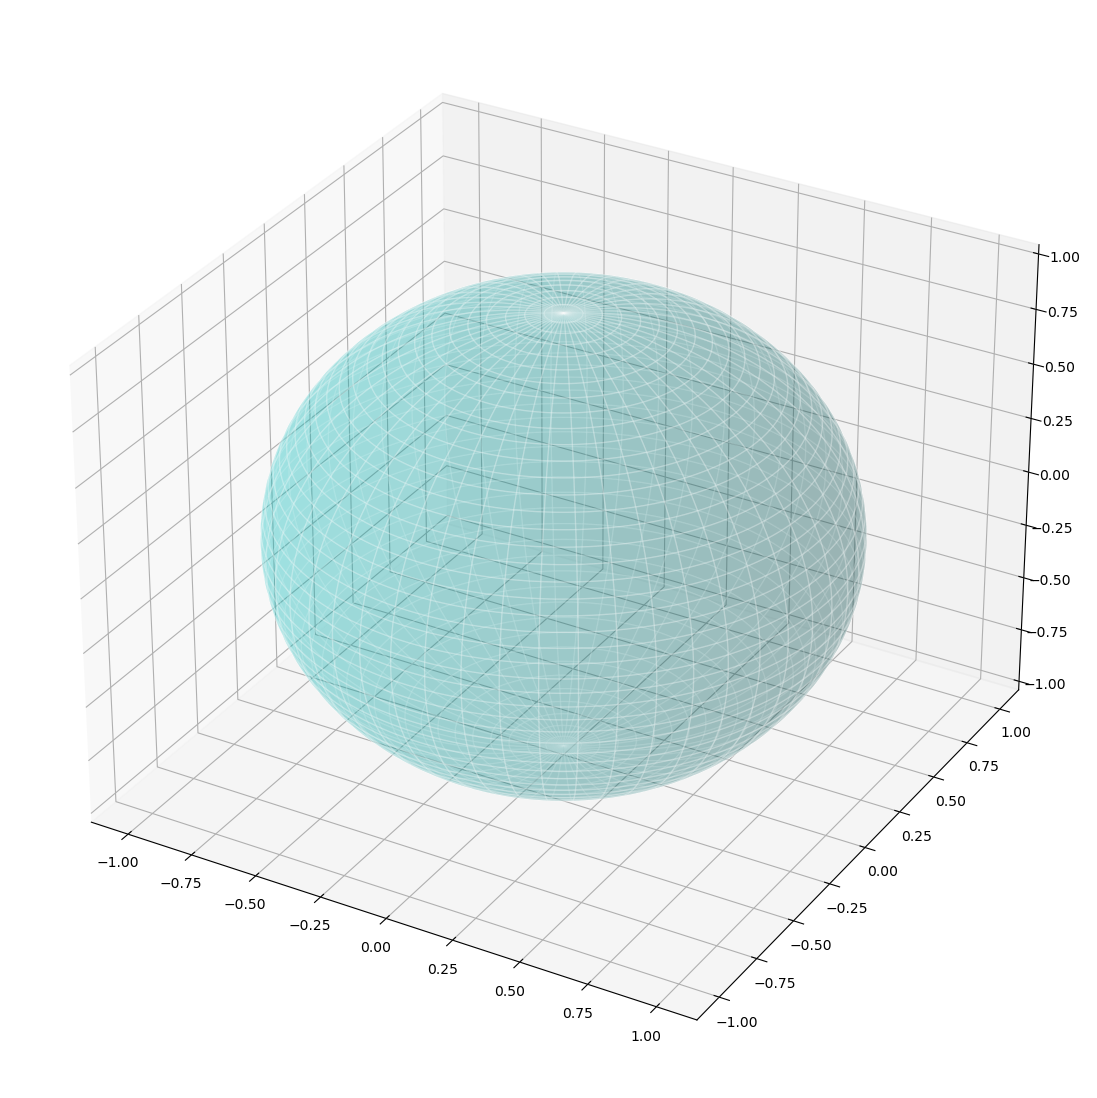

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

nFrames = 10
nMolecule = 800

# f = open('comp-800-1.dpl.all.txt')
f = open('/ocean/projects/see220002p/shared/LAMMPS/Folder-for-Omar/Water-Slit-Pore/water-slit-pore-n800-10-analysis.dpl.all.txt')
data_str = f.readlines()[4:(nMolecule + 5)+(nMolecule + 1)*nFrames]
f.close()

nTimestamp = int(len(data_str)/(nMolecule + 1))
slabEdges = [zBinEdge[0],(zBinEdge[1]+zBinEdgePeaks[0])/2]
# slabEdges = [-11.5,-9.5]

dipoleVectors = []
normVec = []
normVecInBin = []
for i in data_str:
    parts = i.split()
    if len(parts) == 8:  # Check if there are exactly 5 columns
        if float(parts[7]) == 0:
            continue
        index = int(parts[0])  # molecule index (can be ignored for now)
        xCOM = float(parts[1])
        yCOM = float(parts[2])
        zCOM = float(parts[3])
        x = float(parts[4])
        y = float(parts[5])
        z = float(parts[6])
        magnitude = float(parts[7])
        dipoleVectors.append([x, y, z, magnitude])
        normVec.append([x/magnitude, y/magnitude, z/magnitude])
        if slabEdges[0] <= zCOM < slabEdges[1]:
            normVecInBin.append([x/magnitude, y/magnitude, z/magnitude])

# Convert to a NumPy array for easier processing
dipoleVectors = np.array(dipoleVectors)
normVec = np.array(normVec)
normVecInBin = np.array(normVecInBin)

# Create a 3D plot for visualization
mm = 1/25.4  # millimeters in inches
# fig = plt.figure(figsize=(2*70*mm,2*50*mm), dpi=200)  # create a figure object
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the sphere
u = np.linspace(0, 2 * np.pi, 1000)
v = np.linspace(0, np.pi, 1000)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# ax.plot_surface(x, y, z, color='c', alpha=0.3, edgecolor='w')
ax.plot_surface(x, y, z, color='c', alpha=0.2,  edgecolor='w') #cmap='viridis') #,

# Plot the normalized vectors as points on the sphere's surface
# ax.scatter(avgNormVec[:, 0], avgNormVec[:, 1], avgNormVec[:, 2], color='#045a8d', s=50, edgecolor = 'k')
ax.scatter(normVecInBin[:,0], normVecInBin[:, 1], normVecInBin[:, 2], color='#045a8d', s=50, edgecolor = 'k')
# ax.scatter(normVec[-400:, 0], normVec[-400:, 1], normVec[-400:, 2], color='#045a8d', s=50, edgecolor = 'k')


# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Dipole Vectors as Points on the Surface of a Sphere')
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

plt.show()
# fig.savefig("norm-dipole-proj-sphere-1000-confinement.png", format="png")   

# Display first few normalized vectors for verification
# print(avgNormVec[:5])


In [7]:
slabEdges

[-30, -11.55]

In [8]:
normVecInBin

array([], dtype=float64)